# 多周期信号加权策略

本策略将使用同一个信号在不同周期的加权平均，来构造总体的信号。

目前使用的是ema和ma的交叉。

In [1]:
import Neilyst

# 回测时间为2023年一年
start_time = '2023-01-01T00:00:00Z'
end_time = '2023-01-02T00:00:00Z'
symbol = 'BTC/USDT'

# 获取数据
data_1h = Neilyst.get_klines(symbol, start_time, end_time, timeframe='15m')
data_30m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='30m')
data_15m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='15m')
data_5m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='5m')
data_1m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='1m')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# 计算指标

indicators_1h = Neilyst.get_indicators(data_1h, 'sma20', 'ema9')
indicators_30m = Neilyst.get_indicators(data_30m, 'sma20', 'ema9')
indicators_15m = Neilyst.get_indicators(data_15m, 'sma20', 'ema9')
indicators_5m= Neilyst.get_indicators(data_5m, 'sma20', 'ema9')
indicators_1m= Neilyst.get_indicators(data_1m, 'sma20', 'ema9')

In [3]:
class MultiSignalStrategy(Neilyst.Strategy):
    def __init__(self, total_balance, trading_fee_ratio, slippage_ratio, data=None, indicators=None):
        super().__init__(total_balance, trading_fee_ratio, slippage_ratio, data, indicators)
        self.take_profit_ratio = 0.2 #止盈比例
        self.stop_loss_ratio = -0.1 #止损比例
    
    def run(self, date, price_row, current_pos, current_balance):
        recent_data_15m = self.get_recent_data(date, 2, data_1h, indicators_1h)
        signal = None
        
        if len(recent_data_15m) >= 2:
            ema_15 = recent_data_15m.iloc[-1]['ema9']
            ma_15 = recent_data_15m.iloc[-1]['sma20']

            prev_ema_15 = recent_data_15m.iloc[0]['ema9']
            prev_ma_15 = recent_data_15m.iloc[0]['sma20']

            # 先处理信号
            index = 0
            if (ema_15 > ma_15) and (prev_ema_15 < prev_ma_15):
                # 多信号
                index = -1
            if (ema_15 < ma_15) and (prev_ema_15 > prev_ma_15):
                index = 1

            if current_pos.amount > 0:
                # 此时有仓位，考虑平仓过程

                # 先看信号是否翻转
                if current_pos.dir == 'long':
                    # 此时多仓
                    if ema_15 <= ma_15:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                
                if current_pos.dir == 'short':
                    if ema_15 >= ma_15:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)

                # 固定止盈止损、或者布林带止盈，ma止损
                open_total_price = current_pos.open_price * current_pos.amount
                if (current_pos.float_profit / open_total_price) >= self.take_profit_ratio:
                    #止盈
                    signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                elif (current_pos.float_profit / open_total_price) <= self.stop_loss_ratio:
                    #止损
                    signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)

            else:
                # 没有仓位，考虑开仓信号

                # 根据信号计算仓位
                pos = abs(current_balance / price_row['close'] * index)

                # 开仓
                if index > 0:
                    signal = Neilyst.Signal('long', price_row['close'], pos)
                elif index < 0:
                    signal = Neilyst.Signal('short', price_row['close'], pos)

        return signal
    
    # 仓位管理，考虑写入框架的策略：网格
    def pos_management(self):
        pass

In [4]:
init_balance = 50000
strategy = MultiSignalStrategy(init_balance, 0, 0, None, None)
result = Neilyst.backtest(symbol, start_time, end_time, strategy)
evaluation = Neilyst.evaluate_strategy(result, init_balance)

evaluation


 21%|██▏       | 309/1440 [00:00<00:01, 959.43it/s] /Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
 29%|██▉       | 415/1440 [00:00<00:01, 990.15it/s]/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
 36%|███▋      | 523/1440 [00:00<00:00, 1019.94it/s]/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: 

总收益: -55.18899358939079
总胜率: 0.359375
盈亏比: 0.8571034886109453
最大回撤: 67.46027412199962
年化收益率: 0%
夏普比率: -17.76811595454667


{'total_pnl': -55.18899358939079,
 'win_rate': 0.359375,
 'profit_loss_ratio': 0.8571034886109453,
 'max_drawdown': 67.46027412199962,
 'annual_return': 0,
 'sharpe_ratio': -17.76811595454667}

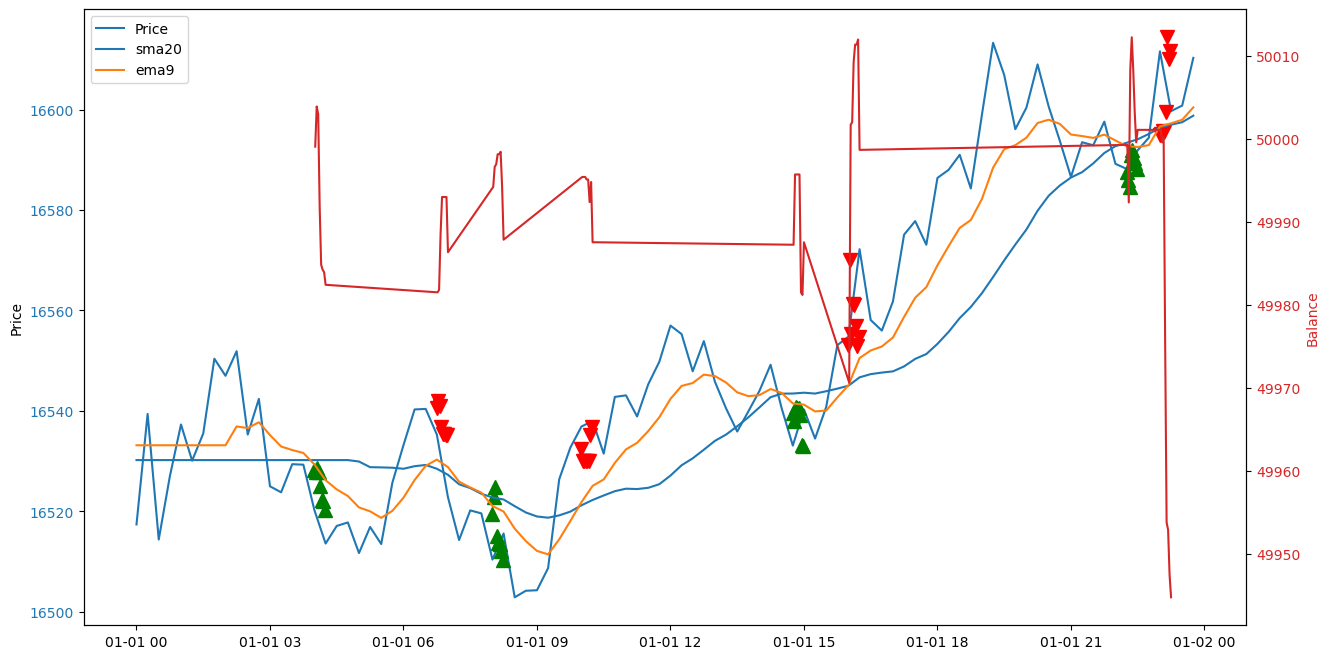

In [5]:
Neilyst.show_pnl(data_15m, indicators_15m, result, init_balance)